# Lab 1: Supervised Learning (2D, 2 classes)

- Dataset: Bank Marketing (binary target `y`), using exactly two numeric features
- Goals: visualize data, implement in-house LDA, train 3–4 out-of-box classifiers, plot ROC curves and confusion-matrix heatmaps, and benchmark their performance.
- Features: use `duration` and `pdays`.



In [40]:
# Imports
# This notebook demonstrates supervised learning on a 2D, 2-class dataset.
# We will use: numpy/pandas for data handling, matplotlib/seaborn for visualization,
# and scikit-learn for standard classifiers and metrics.

import os
import sys
import math
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import dataclass
from typing import Tuple, Dict, Any

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    roc_curve,
    auc,
    confusion_matrix,
    classification_report,
)

# Out-of-box classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Plot style
sns.set(context="notebook", style="whitegrid", palette="deep")
np.random.seed(42)



In [41]:
# Bank Marketing dataset loader (2D, binary)
# Use fixed features: duration and balance (balance as income proxy).

DATA_DIR = pathlib.Path("../datasets")
BANK_CANDIDATES = [
    DATA_DIR / "bank.csv",
    DATA_DIR / "bank-full.csv",
    DATA_DIR / "bank_marketing.csv",
    DATA_DIR / "bank-additional-full.csv",
]


def load_bank_marketing_two_features() -> Tuple[np.ndarray, np.ndarray, Tuple[str, str]]:
    # Locate CSV
    for csv_path in BANK_CANDIDATES:
        if csv_path.exists():
            df = pd.read_csv(csv_path)
            break
    else:
        raise FileNotFoundError(
            "Bank Marketing CSV not found in datasets/. Place file as bank.csv or bank-additional-full.csv."
        )

    # Normalize column names to lower-case for consistency
    df = df.rename(columns={c: c.lower() for c in df.columns})

    # Determine target column
    if "y" in df.columns:
        target_col = "y"
    elif "deposit" in df.columns:
        target_col = "deposit"
    elif "target" in df.columns:
        target_col = "target"
    else:
        target_col = df.columns[-1]

    y_raw = df[target_col]
    # Map labels to {0,1}
    if y_raw.dtype == object:
        y_series = y_raw.astype(str).str.lower().map({"yes": 1, "no": 0})
        if y_series.isna().any():
            classes = sorted(y_raw.dropna().astype(str).str.lower().unique())
            mapping = {cls: i for i, cls in enumerate(classes[:2])}
            y_series = y_raw.astype(str).str.lower().map(mapping)
    else:
        classes = np.sort(y_raw.unique())
        mapping = {cls: i for i, cls in enumerate(classes[:2])}
        y_series = y_raw.map(mapping)

    y = y_series.astype(int).to_numpy()

    # Fixed features
    feature_names = ("duration", "pdays")
    for col in feature_names:
        if col not in df.columns:
            raise ValueError(f"Required feature '{col}' not present in CSV")

    X_df = df[list(feature_names)].copy()
    X_df = X_df.replace([np.inf, -np.inf], np.nan)
    X_df = X_df.fillna(X_df.median(numeric_only=True))

    X = X_df.to_numpy(dtype=float)
    return X, y, feature_names


# Load dataset
X, y, feature_names = load_bank_marketing_two_features()
data_source = "bank_marketing"
print(f"Data source: {data_source}, shape: {X.shape}, pos ratio: {y.mean():.3f}")
print("Selected features:", feature_names)



Data source: bank_marketing, shape: (11162, 2), pos ratio: 0.474
Selected features: ('duration', 'pdays')


In [42]:
# Train-test split and scaling
# We standardize features on the training data and apply the transformation to both sets.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

print(
    f"Train: {X_train_std.shape}, Test: {X_test_std.shape}, Class balance train: {y_train.mean():.3f}, features: {feature_names}"
)



Train: (7813, 2), Test: (3349, 2), Class balance train: 0.474, features: ('duration', 'pdays')


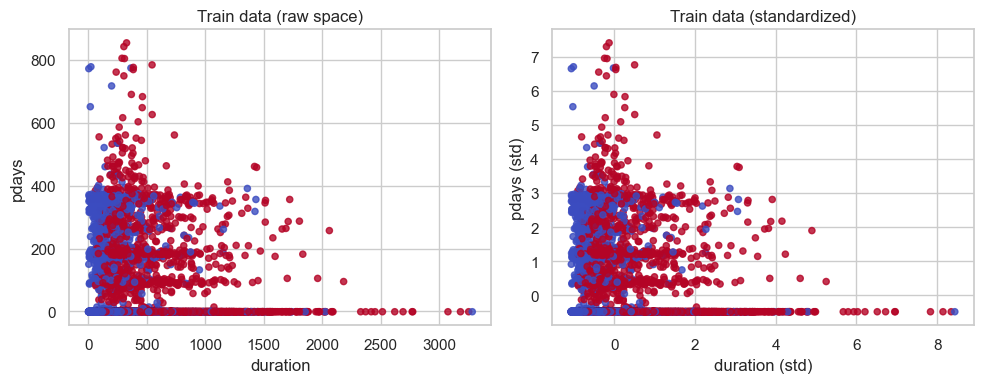

In [43]:
# Visualize the distribution of the 2D sample (train split)
# We show raw and standardized spaces for intuition.

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Raw space
axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="coolwarm", s=20, alpha=0.8)
axes[0].set_title("Train data (raw space)")
axes[0].set_xlabel(str(feature_names[0]))
axes[0].set_ylabel(str(feature_names[1]))

# Standardized space
axes[1].scatter(X_train_std[:, 0], X_train_std[:, 1], c=y_train, cmap="coolwarm", s=20, alpha=0.8)
axes[1].set_title("Train data (standardized)")
axes[1].set_xlabel(str(feature_names[0]) + " (std)")
axes[1].set_ylabel(str(feature_names[1]) + " (std)")

plt.tight_layout()
plt.show()



In [44]:
# In-house Gaussian LDA (from first principles)
# We assume class-conditional Gaussians with a shared covariance matrix.
# The discriminant is linear in x: g_k(x) = w^T x + w0. We estimate
# class means and shared covariance from the training data.

@dataclass
class InHouseLDA:
    # No hyperparameters for basic LDA
    means_: np.ndarray = None          # shape (2, d)
    shared_cov_: np.ndarray = None     # shape (d, d)
    shared_cov_inv_: np.ndarray = None # shape (d, d)
    priors_: np.ndarray = None         # shape (2,)
    w_: np.ndarray = None              # shape (d,)
    w0_: float = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> "InHouseLDA":
        X = np.asarray(X)
        y = np.asarray(y)
        classes = np.unique(y)
        assert len(classes) == 2, "This simple implementation supports binary classification only"
        d = X.shape[1]

        # Class means
        mu0 = X[y == 0].mean(axis=0)
        mu1 = X[y == 1].mean(axis=0)
        self.means_ = np.vstack([mu0, mu1])

        # Shared covariance (pooled estimate)
        S0 = np.cov(X[y == 0].T, bias=False)
        S1 = np.cov(X[y == 1].T, bias=False)
        n0 = (y == 0).sum()
        n1 = (y == 1).sum()
        Sp = ((n0 - 1) * S0 + (n1 - 1) * S1) / (n0 + n1 - 2)
        self.shared_cov_ = Sp
        self.shared_cov_inv_ = np.linalg.pinv(Sp)

        # Class priors
        self.priors_ = np.array([n0 / (n0 + n1), n1 / (n0 + n1)], dtype=float)

        # Discriminant parameters
        self.w_ = self.shared_cov_inv_.dot(mu1 - mu0)
        # Intercept includes quadratic terms canceling out under shared covariance
        self.w0_ = (
            -0.5 * mu1.T.dot(self.shared_cov_inv_).dot(mu1)
            + 0.5 * mu0.T.dot(self.shared_cov_inv_).dot(mu0)
            + math.log(self.priors_[1] / self.priors_[0])
        )
        return self

    def decision_function(self, X: np.ndarray) -> np.ndarray:
        X = np.asarray(X)
        return X.dot(self.w_) + self.w0_

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        # Map linear score to probability with logistic link
        scores = self.decision_function(X)
        p1 = 1.0 / (1.0 + np.exp(-scores))
        return np.c_[1 - p1, p1]

    def predict(self, X: np.ndarray) -> np.ndarray:
        proba = self.predict_proba(X)
        return (proba[:, 1] >= 0.5).astype(int)


# Train on standardized space (common practice for linear models)
inhouse_lda = InHouseLDA().fit(X_train_std, y_train)
y_pred_ih = inhouse_lda.predict(X_test_std)
y_proba_ih = inhouse_lda.predict_proba(X_test_std)[:, 1]

print("In-house LDA accuracy:", accuracy_score(y_test, y_pred_ih))



In-house LDA accuracy: 0.7279785010450881


In [45]:
# Train and evaluate out-of-box classifiers
# We'll use Logistic Regression, scikit-learn LDA, Gaussian Naive Bayes, and SVM (RBF) as examples.

classifiers = {
    "logreg": LogisticRegression(max_iter=1000),
    "sk_lda": LinearDiscriminantAnalysis(),
    "gnb": GaussianNB(),
    "svm_rbf": SVC(probability=True, kernel="rbf", C=1.0, gamma="scale"),
}

results: Dict[str, Dict[str, Any]] = {}

for name, clf in classifiers.items():
    # Note: some classifiers (e.g., GNB) work better on raw features; however, we keep standardized features for consistency.
    clf.fit(X_train_std, y_train)
    y_pred = clf.predict(X_test_std)
    y_proba = clf.predict_proba(X_test_std)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    results[name] = {
        "model": clf,
        "y_pred": y_pred,
        "y_proba": y_proba,
        "accuracy": acc,
        "fpr": fpr,
        "tpr": tpr,
        "auc": roc_auc,
    }

print({k: round(v["accuracy"], 3) for k, v in results.items()})



{'logreg': 0.732, 'sk_lda': 0.728, 'gnb': 0.697, 'svm_rbf': 0.773}


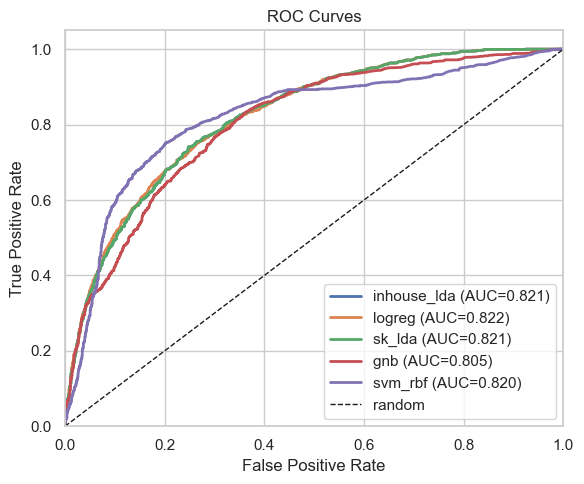

In [46]:
# ROC curves for in-house LDA and out-of-box classifiers

plt.figure(figsize=(6, 5))

# In-house LDA ROC
fpr_ih, tpr_ih, _ = roc_curve(y_test, y_proba_ih)
auc_ih = auc(fpr_ih, tpr_ih)
plt.plot(fpr_ih, tpr_ih, label=f"inhouse_lda (AUC={auc_ih:.3f})", lw=2)

# Others
for name, res in results.items():
    plt.plot(res["fpr"], res["tpr"], label=f"{name} (AUC={res['auc']:.3f})", lw=2)

plt.plot([0, 1], [0, 1], "k--", lw=1, label="random")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()



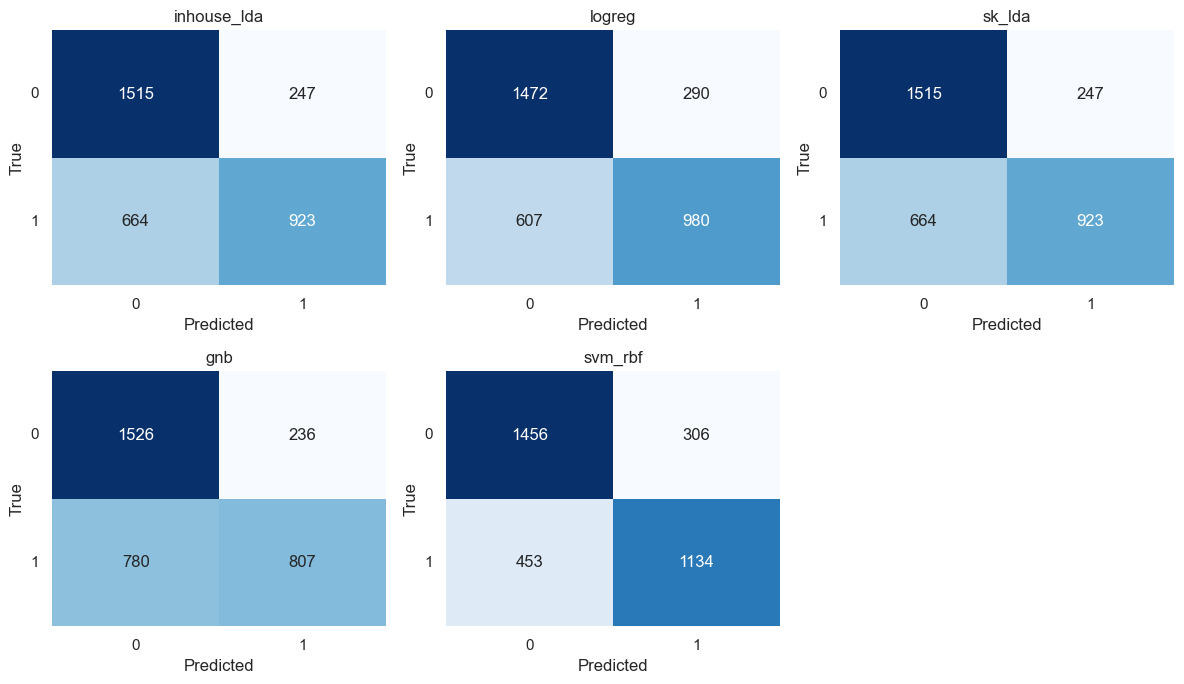

In [47]:
# Confusion matrix heatmaps (hit maps)

from itertools import product

def plot_confusion_heatmap(ax, cm: np.ndarray, title: str):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    ax.set_xticklabels(["0", "1"])  # ensure binary order
    ax.set_yticklabels(["0", "1"], rotation=0)

models_for_heatmap = [("inhouse_lda", y_pred_ih)] + [
    (name, res["y_pred"]) for name, res in results.items()
]

n_models = len(models_for_heatmap)
cols = 3
rows = int(np.ceil(n_models / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3.5*rows))
axes = np.array(axes).reshape(rows, cols)

for idx, (name, preds) in enumerate(models_for_heatmap):
    r, c = divmod(idx, cols)
    cm = confusion_matrix(y_test, preds)
    plot_confusion_heatmap(axes[r, c], cm, f"{name}")

# Hide any unused subplots
for idx in range(n_models, rows*cols):
    r, c = divmod(idx, cols)
    axes[r, c].axis('off')

plt.tight_layout()
plt.show()



In [48]:
# Benchmarking table: accuracy and AUC

rows = []
rows.append({
    "model": "inhouse_lda",
    "accuracy": accuracy_score(y_test, y_pred_ih),
    "auc": auc_ih,
})
for name, res in results.items():
    rows.append({
        "model": name,
        "accuracy": res["accuracy"],
        "auc": res["auc"],
    })

benchmark_df = pd.DataFrame(rows).sort_values(by=["auc", "accuracy"], ascending=False)
display(benchmark_df)



,model,accuracy,auc
1,logreg,0.732159,0.822217
0,inhouse_lda,0.727979,0.821295
2,sk_lda,0.727979,0.821295
4,svm_rbf,0.773365,0.820132
3,gnb,0.696626,0.804983
